# Week 2 Project

**Students**: Sergio Casas Pastor, Sanket Biswas and Josep Brugués i Pujolràs

**TEST CODE**

In [1]:
import cv2
import numpy as np

try:
   import cPickle as pickle # Python 2
except:
   import pickle # Python 3

from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import Normalizer, PowerTransformer, MinMaxScaler
import sklearn
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

Let us first read the train and test files

In [2]:
try:
    train_images_filenames = pickle.load(open('train_images_filenames.dat','r'))
    test_images_filenames = pickle.load(open('test_images_filenames.dat','r'))
    train_labels = pickle.load(open('train_labels.dat','r'))
    test_labels = pickle.load(open('test_labels.dat','r'))
except:
    train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
    test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
    train_labels = pickle.load(open('train_labels.dat','rb'))
    test_labels = pickle.load(open('test_labels.dat','rb'))

In [3]:
train_images_filenames[12]

'../../Databases/MIT_split/train/Opencountry/fie26.jpg'

In [4]:
train_labels[12]

'Opencountry'

We create a SIFT object detector and descriptor

In [5]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=900)
start = time.time()

We create a Normalizer

In [6]:
norm = "max" #Valid norms: l1, l2, max, power, minmax

if norm == "power":
    transformer = PowerTransformer() # Defaults to ’yeo-johnson’ method 
                                                     # (Not working with scikit 0.20.4 because of a bug)
elif norm == "minmax":
    transformer = MinMaxScaler() # Defaults to 0-1 range
else: # l1, l2 or max
    try:
        transformer = Normalizer(norm=norm)
    except:
        print("Invalid norm. Using L2 instead")
        transformer = Normalizer(norm="l2")

We compute different spatial pyramid level

In [7]:
level = 1
level = 2**(level-1)

We compute the SIFT descriptors for the all the train images and subsequently build a numpy array with all the descriptors stacked together

In [8]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    
    # Resize image
    scale_percent = 100 # percent of original size
    width = int(ima.shape[1] * scale_percent / 100)
    height = int(ima.shape[0] * scale_percent / 100)
    dim = (width, height)
    ima = cv2.resize(ima, dim, interpolation = cv2.INTER_AREA) 
    
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    step = 8 # Separation of pixels between keypoints
    descriptors = []

    # Compute spatial pyramids
    height_block = int(np.ceil(ima.shape[0] / level))  # Number of height pixels for sub-image
    width_block = int(np.ceil(ima.shape[1] / level))   # Number of width pixels for sub-image
    
    for height in range(0, ima.shape[0], height_block):
        for width in range(0, ima.shape[1], width_block):
            block = gray[height:height + height_block, width:width + width_block]
            keypoints_block = []
        
            for i in range(int(step/2), block.shape[0], step):
                for j in range(int(step/2), block.shape[1], step):             
                    keypoints_block.append(cv2.KeyPoint(i, j, step))
     
            _, descriptors_block = SIFTdetector.compute(block,keypoints_block)
            descriptors.extend(descriptors_block)
    
    Train_descriptors.append(descriptors)
    Train_label_per_descriptor.append(labels)

Train_descriptors = np.array(Train_descriptors)
nsamples, nx, ny = Train_descriptors.shape
Train_descriptors = Train_descriptors.reshape((nsamples,nx*ny))
#nsamples, nx = Train_descriptors.shape
Train_descriptors_scaled = transformer.fit_transform(Train_descriptors)
Train_descriptors_scaled = Train_descriptors_scaled.reshape((nsamples, nx, ny))
D=np.vstack(Train_descriptors_scaled)

We now compute a k-means clustering on the descriptor space

In [9]:
k = 170
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=3400, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=170, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [10]:
visual_words=np.zeros((len(Train_descriptors_scaled),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors_scaled[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors. We use GridSearchCV to do Cross-Validation and find the best parameters of the k-nn classifier.

Parameters set found on development set:


c:\users\sergio\desktop\machine learning for cv\project\mcv-2019-m3\venv\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


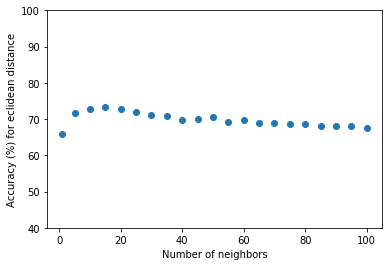

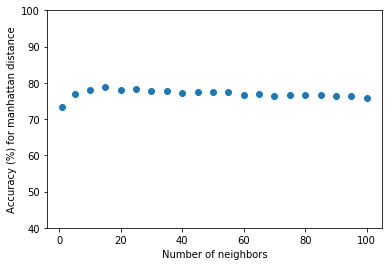

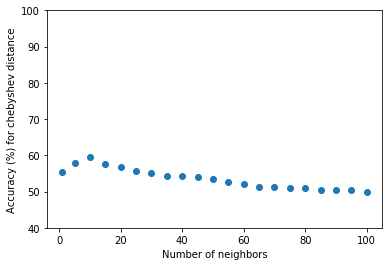

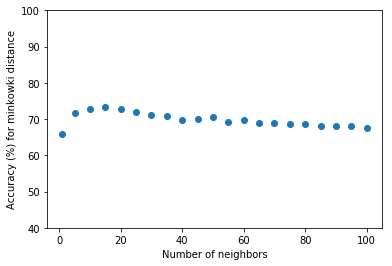

('Maximum accuracy for validation set is', 78.73471557682083, 'with n_neighbors =', 15, 'and metric =', 'manhattan')


In [11]:
parameters = {'n_neighbors':[1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], \
              'metric':['euclidean','manhattan','chebyshev','minkowski']}
knn = KNeighborsClassifier(n_jobs=-1)
clf = GridSearchCV(knn, parameters, cv=5) # StratifiedKFold n_splits = 5
clf.fit(visual_words, train_labels) 

print("Parameters set found on development set:")
means = 100 * clf.cv_results_['mean_test_score']

plt.scatter(parameters['n_neighbors'], means[0:21])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%) for eclidean distance")
plt.ylim((40,100))
plt.show()

plt.scatter(parameters['n_neighbors'], means[21:42])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%) for manhattan distance")
plt.ylim((40,100))
plt.show()

plt.scatter(parameters['n_neighbors'], means[42:63])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%) for chebyshev distance")
plt.ylim((40,100))
plt.show()

plt.scatter(parameters['n_neighbors'], means[63:84])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%) for minkowki distance")
plt.ylim((40,100))
plt.show()

print ("Maximum accuracy for validation set is", max(means), "with n_neighbors =", clf.best_params_['n_neighbors'], "and metric =",  clf.best_params_['metric']) 


We end up computing the test descriptors and compute the accuracy of the model

In [12]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
Test_descriptors = []
for image in range(len(test_images_filenames)):
    filename=test_images_filenames[image]
    ima=cv2.imread(filename)
    
    # Resize image
    width = int(ima.shape[1] * scale_percent / 100)
    height = int(ima.shape[0] * scale_percent / 100)
    dim = (width, height)
    ima = cv2.resize(ima, dim, interpolation = cv2.INTER_AREA) 
    
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            
    descriptors = []

    # Compute spatial pyramids
    height_block = int(np.ceil(ima.shape[0] / level))  # Number of height pixels for sub-image
    width_block = int(np.ceil(ima.shape[1] / level))    # Number of width pixels for sub-image
    for height in range(0, ima.shape[0], height_block):
        for width in range(0, ima.shape[1], width_block):
            block = gray[height:height + height_block, width:width + width_block]
            keypoints_block = []
    
            for i in range(int(step/2), block.shape[0], step):
                for j in range(int(step/2), block.shape[1], step):             
                    keypoints_block.append(cv2.KeyPoint(i, j, step))
            
            _, descriptors_block = SIFTdetector.compute(block,keypoints_block)   
            descriptors.extend(descriptors_block)
    
    Test_descriptors.append(descriptors)
    
Test_descriptors = np.array(Test_descriptors)
nsamples, nx, ny = Test_descriptors.shape
Test_descriptors = Test_descriptors.reshape((nsamples, nx*ny))
Test_descriptors_scaled = transformer.transform(Test_descriptors)
Test_descriptors_scaled = Test_descriptors_scaled.reshape((nsamples, nx, ny))

for image in range(len(test_images_filenames)):
    words=codebook.predict(Test_descriptors_scaled[image])
    visual_words_test[image,:]=np.bincount(words,minlength=k) 

Compute the accuracy of the model

In [13]:
accuracy = 100*clf.score(visual_words_test, test_labels)
print(accuracy)
end = time.time()
print(end - start)

77.44733581164807
218.126999855


Dimensionality reduction, with PCA and LDA

In [16]:
pca = PCA(n_components=None)
VWpca = pca.fit_transform(visual_words)

parameterspca = {'n_neighbors':[1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], \
              'metric':['euclidean','manhattan','chebyshev','minkowski']}
knnpca = KNeighborsClassifier(n_jobs=-1)
clfpca = GridSearchCV(knnpca, parameters, cv=5) # StratifiedKFold n_splits = 5
clfpca.fit(VWpca, train_labels) 
meanspca = 100 * clfpca.cv_results_['mean_test_score']
print ("Maximum accuracy for validation set is", max(meanspca), "with n_neighbors =", clfpca.best_params_['n_neighbors'], "and metric =",  clfpca.best_params_['metric']) 

vwtestpca = pca.transform(visual_words_test)
accuracy = 100*clfpca.score(vwtestpca, test_labels)
print(accuracy)

('Maximum accuracy for validation set is', 73.20574162679426, 'with n_neighbors =', 15, 'and metric =', 'euclidean')
74.34944237918215


In [17]:
lda = LinearDiscriminantAnalysis(n_components=None)
VWlda = lda.fit_transform(visual_words,train_labels)

parameterslda = {'n_neighbors':[1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], \
              'metric':['euclidean','manhattan','chebyshev','minkowski']}
knnlda = KNeighborsClassifier(n_jobs=-1)
clflda = GridSearchCV(knnlda, parameters, cv=5) # StratifiedKFold n_splits = 5
clflda.fit(VWlda, train_labels) 
meanslda = 100 * clflda.cv_results_['mean_test_score']
print ("Maximum accuracy for validation set is", max(meanslda), "with n_neighbors =", clflda.best_params_['n_neighbors'], "and metric =",  clflda.best_params_['metric']) 

vwtestlda = lda.transform(visual_words_test)
accuracy = 100*clflda.score(vwtestlda, test_labels)
print(accuracy)

c:\users\sergio\desktop\machine learning for cv\project\mcv-2019-m3\venv\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


('Maximum accuracy for validation set is', 88.41041998936736, 'with n_neighbors =', 50, 'and metric =', 'euclidean')
82.28004956629492


**RESULTS AND DISCUSSION**

We first implemented Dense SIFT. Compared to last weeks's results, 
we improved around 10-15%, depending on dimensionality reduction and other factors.
Then, we analysed the behaviour of Dense SIFT when changing the number of pixels between keypoints.
The results can be seen in the following graphic:

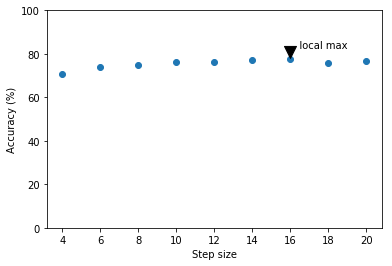

Local max is 77.69 % accuracy at step= 16


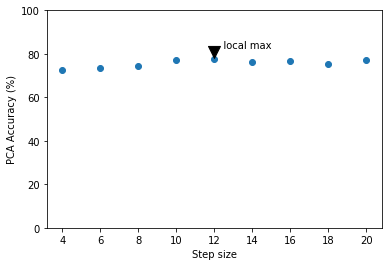

Local max is 77.69 % PCA accuracy at step= 12


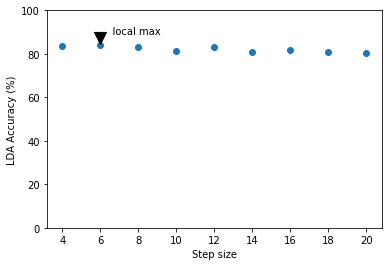

Local max is 84.13 % LDA accuracy at step= 6


In [18]:
step = [4,6,8,10,12,14,16,18,20]
accuracy = [70.63,74.10,75.09,76.08,76.08,77.32,77.69,75.58,76.70]
lda_accuracy = [83.39,84.13,83.27,81.16,83.27,81.04,81.9,80.79,80.17]
pca_accuracy = [72.49,73.60,74.34,77.32,77.69,76.08,76.70,75.24,77.19]

plt.scatter(step, accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = step[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% accuracy at step=",xmax

plt.scatter(step, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = step[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% PCA accuracy at step=",xmax


plt.scatter(step, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = step[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

plt.show()
print "Local max is", ymax,"% LDA accuracy at step=",xmax


We ave decided that a step of 8 pixels is the best one, as it accomplishes
one of the best LDA accuracies while not taking much time to complete the computations.

After that, we resized the images to new scales to see if the performance 
could be further improved:

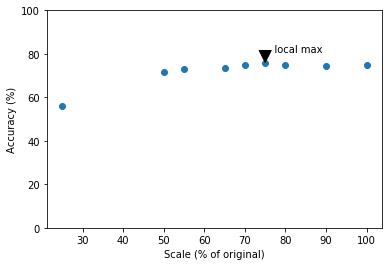

Local max is 75.83 % accuracy at scale= 75


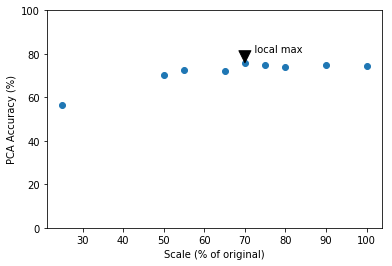

Local max is 75.71 % PCA accuracy at scale= 70


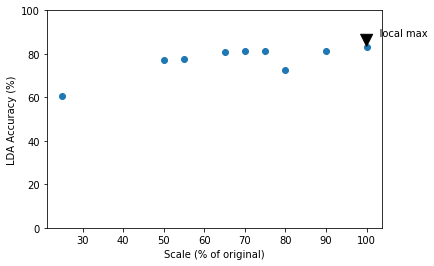

Local max is 83.27 % LDA accuracy at scale= 100


In [19]:
scale = [100,90,80,75,70,65,55,50,25]
accuracy = [75.09,74.47,74.72,75.83,75.09,73.60,72.86,71.49,55.88]
lda_accuracy = [83.27,81.53,72.42,81.53,81.53,80.66,77.57,77.32,60.47]
pca_accuracy = [74.34,74.71,74.10,74.84,75.71,72.24,72.49,70.38,56.50]

plt.scatter(scale, accuracy)
plt.ylim((0, 100))
plt.xlabel("Scale (% of original)")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = scale[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% accuracy at scale=",xmax

plt.scatter(scale, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Scale (% of original)")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = scale[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% PCA accuracy at scale=",xmax


plt.scatter(scale, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Scale (% of original)")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = scale[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

plt.show()
print "Local max is", ymax,"% LDA accuracy at scale=",xmax

As it can be seen from before, the best results are accomplished when the image
is not resized (we take into account the highest accuracy, LDA at scale 100%).

